This notebook shows how to write the output of CHASM to a CORSIKA IACT eventio format file. First let's make a CHASM simulation.

In [9]:
%matplotlib widget
import numpy as np
import CHASM as ch
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import eventio
from scipy.stats import iqr

THETA = np.deg2rad(30.)
PHI = np.deg2rad(45.)
OBS = 0.
grid_side = np.linspace(-1000,1000,10)
TELX, TELY = np.meshgrid(grid_side,grid_side)
TELZ = np.full_like(TELX, OBS)
TEL_VECTORS = np.vstack((TELX.flatten(), TELY.flatten(), TELZ.flatten())).T

sim = ch.ShowerSimulation()
sim.add(ch.DownwardAxis(THETA, PHI, OBS))
sim.add(ch.SphericalCounters(TEL_VECTORS,.1))
sim.add(ch.GHShower(600,1.e6,0.,70))
sim.add(ch.Yield(300,450,1))

Now let's run the simulation to create a ShowerSignal object.

In [2]:
sig = sim.run()

We can also run with the shower mesh option, this will take a bit longer.

In [3]:
sig_mesh = sim.run(mesh=True)

Now we can make IACT files from these signals.

In [4]:
ei_filename = 'iact.dat'
ei_filename_mesh = 'iact_mesh.dat'

ch.write_ei_file(sig, ei_filename)
ch.write_ei_file(sig_mesh, ei_filename_mesh)

Now let's read in these files with the eventio reader.

In [5]:
ei = eventio.IACTFile(ei_filename)
ei_mesh = eventio.IACTFile(ei_filename_mesh)

Now let's look at the approximate coordinates of the bunch origins (minus the offset between the surface of the spherical IACT and its center. We use a built in CHASM function to do this.

In [6]:
x,y,z,p = ch.bunch_origins(ei)
xm,ym,zm,pm = ch.bunch_origins(ei_mesh)

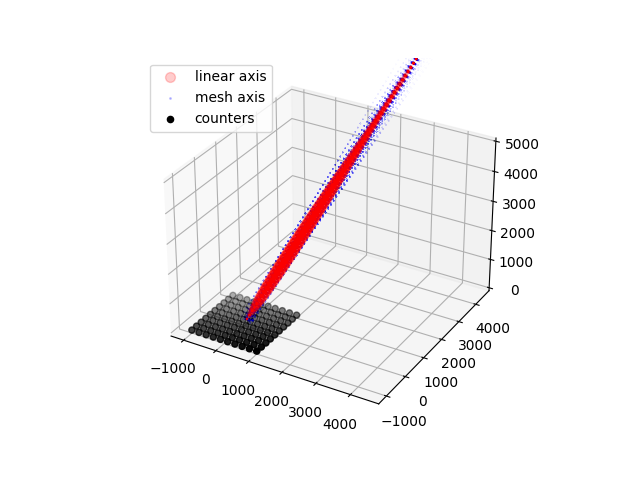

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x, y ,z ,c='r', s=100*p/p.max(), alpha=0.2, label='linear axis')
ax.scatter(xm, ym ,zm ,c='b', s=100*pm/p.max(), alpha=0.2, label='mesh axis')
ax.scatter(TEL_VECTORS[:,0],TEL_VECTORS[:,1],TEL_VECTORS[:,2], c='k', label = 'counters')
ax.set_zlim(0,5000)
plt.legend();

We can also plot the photons arriving at one counter by accessing the bunches.

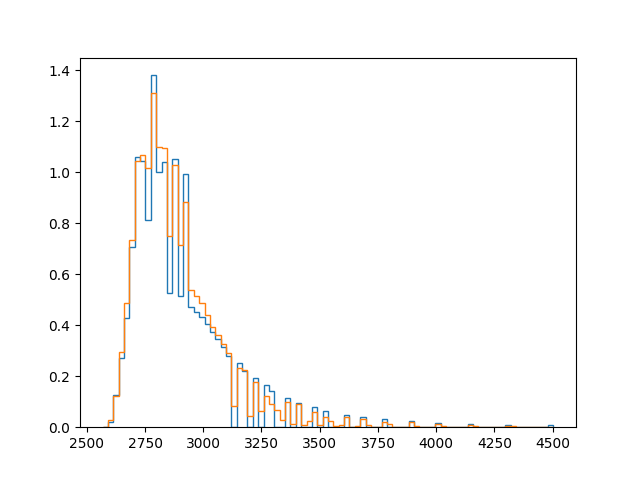

In [8]:
event = next(iter(ei))
event_mesh = next(iter(ei_mesh))
bins = event.photon_bunches[0]['time'].min() , event.photon_bunches[0]['time'].max()
nbins = event.photon_bunches[0]['time'].size
plt.figure()
plt.hist(event.photon_bunches[0]['time'],nbins,bins,weights = event.photon_bunches[0]['photons'],histtype='step')
plt.hist(event_mesh.photon_bunches[0]['time'],nbins,bins,weights = event_mesh.photon_bunches[0]['photons'],histtype='step');